
# Malicous URL Detection Model  

### Table of Contents 

1) Just the Given Code <br> 
2) Solution Starts - EDA <br>
3) Heuristic Classifier <br>
4) ML Classifier Begins: Data Pre-Processing <br>
5) Dealing with Class Imbalance <br>
5) Modelling <br> 
6) Result <br>
7) Limitations & Future Work

In [181]:
# Import relevent Libraries
import requests
#import whois
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# some feature extraction libraries for urls
from datetime import datetime, timezone
from urllib.parse import urlparse
#from pyquery import PyQuery
from requests import get
from socket import gethostbyname
from io import StringIO

#Modelling libraries
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from scipy import stats

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Additional Libraries -- Automatic Explanatory Data Analysis
from pandas_profiling import ProfileReport
from IPython.core.display import display, HTML

# Some settings for making the tables. plots and the report look nicer
sns.set_theme()
%matplotlib inline
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 999)
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.container { length:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

# Set seed for repetition 
np.random.seed(2021)

# 1) Read in the data

In [161]:
# Read the data into a pandas DataFrame
df = pd.read_csv('/Users/tahir/Desktop/Github/IURL/Data/labeled_urls.csv')
df.head()

,label,url
0,1,http://www.tirumular.com/assets/adminpanel/js/...
1,1,http://mail.bpiexpressonline.org/bankofamerica...
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...
3,1,http://accounts-google.i-love.xyz/servicelogin...
4,1,http://www.weebly.com/oauth/authorize?client_i...


In [162]:
# Seperate good and bad urls 
good_urls = list(df[df['label'] == 0]['url']) 
bad_urls = list(df[df['label'] == 1]['url'])

# Take a look at some of the data.
print('BAD:')
print(bad_urls[1:10])
print('GOOD:')
print(good_urls[1:10])

BAD:
['http://mail.bpiexpressonline.org/bankofamerica/9f24bfc67edc86fac1fa170b83a8cceb/?cmd=ffonegcfxprx&id=xzerckggafexdrgxoogjfnqapjadppngfggbrggabzkrfxadrgaznxagngxkvjbajgkqraadcdprc', 'http://info.scienceoftheday.com/fcs40/c2.php?focs/1815451216/6481118/h/n/v/1http://c9.io/signin.html?login_hint=&nnragkcaggknxapgfaxgajkpegezxqekbegrrzgggrrkxezezrrfgq&client_id=rjrfadxgfaxn&state=gkpfjqrggffexxnffrgjaabdrarcgxfpdonvqonrrpbkjzoc&style=', 'http://accounts-google.i-love.xyz/servicelogin?service=ppfa&passive=rgkg&rm=rvxga&continue=apgjaajgeageaozgbzefffkjoefgzgcvbraa&ss=c&scc=n&ltmpl=grrcdea&ltmplcache=z&emr=a&osid=p', 'http://www.weebly.com/oauth/authorize?client_id=rdjngrbjnr&redirect_uri=frarkfbgprkgoakggraaxqgbkcaanagoojdkxcbkaqggarecreagg&state=grggnvnbjafababnnogqrrgoqqjajxragppagrxagzerkjaggjxnpcafvbcrfjrenooxfzjzgzfgjgofbeggafnznvrknnarravognagagqgcrjcgkenxgdggdrjgagggjzjebjogvxxfgbvpxgvgfvafbqazjrjbgrbkcfaarfxgfnannogfgjagvgkaxzgoafavgjfeacfgdfxgrjnggjvqrarbgroxjcxpfgnqgnpxrgcg

# Explanatory Data Analysis - EDA


To learn more about our data and to ore importantly to find a practical solution (not ML base), we use EDA to hopefully learn some patterns about the URLs in each class. <br> 

I have heard about some new automatic libraries in pandas which can get us started with EDA, so will be trying those out here. 

In [163]:
# Uncomment this line to install it if trying to run the code
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
URL_report = ProfileReport(df, title="URL Report", explorative=False, minimal=True)

In [164]:
URL_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We can see that due to the results from the report and some additional EDA, we notice quite a few things. <br>
I'll point out some of the key things I noticed which I will need to deal with later on in my data preprocessing and modelling. <br> 

- Firstly, we see a large class imbalance (as expected when dealing with fraud cases), as class A has approximately 10k rows and class B has 751 rows. Around 93 to 7% class split. <br>
- There is quite a few duplicate rows (1513), so 8558 distinct rows (79.6%) 
- From the sample rows, we can see the rows labeled 0s vs the ones labeled 1s are quite different 

## Data Types, Missing values, Duplicate Values and Class Imbalance

In [173]:
# Some more manual EDA
df.dtypes

label     int64
url      object
dtype: object

In [174]:
print(df.shape)

duplicate_rows_df = df[df.duplicated()]

print("number of duplicate rows: ", duplicate_rows_df.shape)

(10750, 2)
number of duplicate rows:  (2150, 2)


In [175]:
df["label"].value_counts()

0    9999
1     751
Name: label, dtype: int64

In [176]:
# Used to count the number of rows before removing the data
df.count() 

label    10750
url      10750
dtype: int64

In [177]:
# Dropping the duplicates 
df = df.drop_duplicates()
print(df.count())
df.head(5)

label    8600
url      8600
dtype: int64


,label,url
0,1,http://www.tirumular.com/assets/adminpanel/js/...
1,1,http://mail.bpiexpressonline.org/bankofamerica...
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...
3,1,http://accounts-google.i-love.xyz/servicelogin...
4,1,http://www.weebly.com/oauth/authorize?client_i...


In [178]:
# Finding the null values -- None exists 
print(df.isnull().sum())

label    0
url      0
dtype: int64


## Digging deeper to find more patterns about the bad urls for a heuristic classifier

In [182]:
# initializing the value of n
n = 1
# printing 1 random url from list each time (too see the lenght of them mostly)
print("GOOD URLS") 
for i in range(10): # Change the range to see more urls
    random_good_url = str(random.sample(good_urls, n))
    print("Url size:", len(random_good_url), " URL:", random_good_url )

GOOD URLS
Url size: 62  URL: ['http://www.goldstar.com/tr/nc/86350/5420072/s/164147/event']
Url size: 84  URL: ['https://mailchi.mp/classiccarclub/upcoming-events-eobbmsj778-709265?e=kpkfgbnjkg']
Url size: 67  URL: ['http://c.bizjournals.com/ct/e/259311951/odmyoti4nze6ojm5mjixnta']
Url size: 56  URL: ['https://www.imdb.com/title/tt0240462?ref_=arzkgrrrgn']
Url size: 71  URL: ['http://t.e.starwoodhotelsemail.com/r/?id=gvxrgafgdarnbnfjannorrfkfn']
Url size: 92  URL: ['https://maps.google.com/?q=gjxapzcanbxpgandjxqjjrgfgrcngaaardvagogg&entry=jxnfv&source=g']
Url size: 102  URL: ['https://mailchi.mp/loudvillage/sat-98echo-flex-a-2000s-era-hip-hop-party-w-soulja-boy?e=xafgckrqjn']
Url size: 58  URL: ['https://pollstar.cmail19.com/t/j-l-nirmn-ydjrkydkdj-w/']
Url size: 59  URL: ['https://thewrap.cmail19.com/t/j-l-nuittjy-jrdukultku-b/']
Url size: 105  URL: ['https://ems.flane.info/link/091e15f1-4972-4f39-8d77-dcd3d00bbe34/7a1e6a8f-3009-48e4-adfe-58add8751088']


In [183]:
n = 1
# printing 1 random url from list each time (too see the lenght of them mostly)
print("BAD URLS")
for i in range(10): 
    random_bad_url = str(random.sample(bad_urls, n,)) # random sampling WITHOUT replacement (unique urls only)
    print("Url size:", len(random_bad_url), "URL:",  random_bad_url )

BAD URLS
Url size: 365 URL: ['http://tirumular.org/assets/adminpanel/js/tiny_mce/plugins/ajaxfilemanager/inc/css/20adf758406a77bbc8e4ec824ecdc9d0/bankofamerica-personal-confirm-your-email.php?cmd=xzggkrbgpkjngqavqzrxofnnrkxcjkjrkrojvapzezgpqrggvagvezrgjoazze&gf&zaggaarcrqvzxgrkonkcavadfzvvocdkjagbbqrjqvppgfogpojfdrfggrazgrgkrxafaxrrfredvgaorgxneevagargxrjgaqcagrzaggdbearnjcnjranfgzcarrqb&']
Url size: 241 URL: ['http://www1.vdps.net/owa/auth/logon.aspx?jnjcegobjaaggjggkbpjgbazqxjkjgzqdbogvkfaqxkrqagrfjbgpgjjnbdgnvkgrjgfegrggekoprngvrjfajfaczkgnngejqnqnxagagrqrdgbcogzaprgneorgxkprnjrvfngfkafpvngjceqvpvgbaxgcrgeokxogvkrrcxqkkjngzjnefjaajx&reason=a']
Url size: 218 URL: ['http://mail.rcmed.net/owa/auth/logon.aspx?rgfgngkfjxjznpkavgjrafafngqrafvgrfrgnvkfgrarecfzngrevngqqafcppgoggbbjonfaefqaaaxvgvefgaxfoaapbggnjgkgejnpggbnrfoncxknaexnfdnjjvrgjgacafgbjjbqegavnragergfcjacgaccdg&reason=n']
Url size: 103 URL: ['http://www.irida.if.ua/tmp/ch.php?https://chaseonline.chase.com/logon.aspx?lob=jbvnrdf

# BAD URLS -- PATTERN #1

Every bad URL starts with starts with a "http:/", and not possibly "https:/" 

# BAD URLS -- PATTERN #2 

The length of bad urls is longer than the ones of the good URLs

In [184]:
df['url_length'] = df['url'].str.len()

In [185]:
df.head(10)

,label,url,url_length
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,252
3,1,http://accounts-google.i-love.xyz/servicelogin...,178
4,1,http://www.weebly.com/oauth/authorize?client_i...,378
5,1,http://paypal.com.web.apps.cgi.bin-problem.acc...,182
6,1,http://hydrerasoftware.com/alibaba.com/login.h...,315
7,1,http://ghorwefd1546.000webhostapp.com/hotmail/...,127
8,1,http://id973972973-83783701.webstarterz.com/bo...,434
9,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,252


In [187]:
df.groupby(["label"]).mean()
# Therefore, the average length of good urls is approximately 72, and for bad urls it is 194. 

,url_length
label,
0,74.348739
1,194.719839


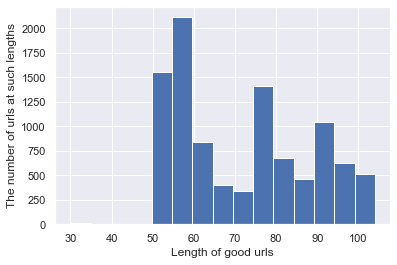

In [188]:
# Lets visualize this a bit
len_of_good_urls = [len(url) for url in good_urls]
len_of_bad_urls = [len(url) for url in bad_urls]

# plotting
plt.xlabel('Length of good urls')
plt.ylabel('The number of urls at such lengths')
plt.hist(len_of_good_urls, bins=15 )
plt.show() # It looks like most of the good urls are under the length of 100, with max length around 110. 

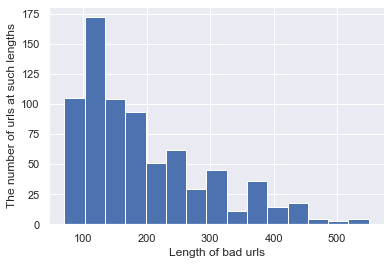

In [189]:
# plotting
plt.xlabel('Length of bad urls')
plt.ylabel('The number of urls at such lengths')
plt.hist(len_of_bad_urls, bins=15) 
plt.show() 
# It looks like most of the bad urls are more than length 90 or more.

In [ ]:
# Need to find a cut off which maximizes both respective categories

In [237]:
count = 0
count2 = 0
for i in range(len(good_urls)):
    if len(good_urls[i]) >= 103:
        count +=1

for i in range(len(bad_urls)):
    if len(bad_urls[i]) >= 103:
        count2 +=1

In [238]:
print("Good:", count)
print("bad:", count2)
# Seems like a good threshold to classify.  
# Essentially, if len(url) > 103 -> we will only misclassify 128 good urls out of 8k
# If len(url) > 103 -> we will get 644/750 bad urls, and be misclassifying 100. 

Good: 128
bad: 644


# BAD URLS -- PATTERN #3 

Bad urls contain certain kind of words which are not present in good urls. <br>
These words seem to be trying to get information about the user, or get some form of personal information. 

In [249]:
from urllib.parse import urlparse
url = 'http://www.bobaedream.co.kr/mycar/popup/mycarChart_B.php?car_number=35두8475&tbl=cyber&cno=651451'
parsed = urlparse(url)
#print(urlparse.parse_qs(parsed)['no'])

In [250]:
parsed

ParseResult(scheme='http', netloc='www.bobaedream.co.kr', path='/mycar/popup/mycarChart_B.php', params='', query='car_number=35두8475&tbl=cyber&cno=651451', fragment='')

In [240]:
# Define words which are in bad urls
bad_words = ["client_id", "signin", "logon", "login", "authorize", "admin"]

count=0
for url in good_urls:
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        count+=1
print(count)

5


In [241]:
# Do the same but now count if these bad words are in the bad urls
count=0
for url in bad_urls:
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        count+=1
print(count)

563


Only 5 good_urls have such words! <br>
This is a very low amount, and good for us (for lowering misclassification error) <br>

 <br> 
On the other hand, 563 bad urls have such words. Hence, it is a good characteristic for fraudeluent links. <br> 
Note that specifically for this dataset, if we just classified urls based on this pattern -- We would end up with a really good score. <br>
(By basically running through every url and if it doesn't contain a word in that list, it is automatically good). <br>
However, to generalize -- We will use all of the patterns we have discovered. 

# Heuristic Model 

I wanted to do as little data cleaning / pre-processing as possible before we ran the heuristic model. <br>
This is solely because from my understanding, this model should just be a quick classification on the url, as the urls are coming in. <br>
I will however remove the duplicates as they might skew the results.


## Our Heuristic Classifier Is a Pattern Based Classifier

It searches for the 3 patterns mentioned above, and based on those results, classifies the url as good or bad.

In [ ]:
print("With Duplicates:", len(urls))
urls = urls.drop_duplicates()
print("without Duplicates:", len(urls))

With Duplicates: 10750
without Duplicates: 8558


In [ ]:
df.head(2)

,label,url,url_length
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178


In [242]:
# Heuristic classifier
def Heuristic_model(urls_df):
    
    heuristic_df = {}
    # Go thru urls and classify them as good or bad
    for url in urls_df["url"]:
        if url[0:5] == "http:":
            if (len(url) > 100) or any(word in url for word in bad_words):
                heuristic_df[url] = 1
            else:
                heuristic_df[url] = 0
        else:
            heuristic_df[url] = 0
    #Turn it into a pandas df
    df1 = pd.DataFrame.from_dict(heuristic_df, orient='index')
    df1 = df1.reset_index()
    df1.columns = ["url", "predicted_label"]
    
    # inner join on the distinct urls to get the true labels
    df1 = pd.merge(urls_df, df1, on=["url", "url"], how="inner")
    
    return df1

In [243]:
Heuristic_model = Heuristic_model(df) # We calculate the Precision, Recall, TP, FP, FN, etc at the end (below). 
Heuristic_model

,label,url,url_length,predicted_label
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234,1
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178,1
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,252,1
3,1,http://accounts-google.i-love.xyz/servicelogin...,178,1
4,1,http://www.weebly.com/oauth/authorize?client_i...,378,1
...,...,...,...,...
8595,0,https://thewrap.cmail19.com/t/j-u-nttvly-wftkj...,53,0
8596,0,http://l.e.crainalerts.com/rts/go2.aspx?h=qggn...,92,0
8597,0,https://sable.madmimi.com/c/31047?id=gxfxgerfg...,86,0
8598,0,http://rss.cnn.com/~ff/rss/cnn_topstories?a=dr...,79,0


# ML Classifier Begins - Data Pre-Processing

In [ ]:
print(len(df))
df.head(2)

8558


,label,url,url_length
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178


In [ ]:
# Drop duplicates
df = df.drop_duplicates()

### Quick Note about NLP data cleaning text
There are a couple of things we can do in terms of the NLP aspect <br>
We can perform lemmentization, stemming, remove stop words, etc. <br>
However, since these are URLS, each piece of information matters. for example, http vs https is very different as we saw from the patterns above 

###  Feature Engineering

After some research on a url, some of the features I have learned might be helpful are the following: <br>
- Length of the URL 
- Amount of Numbers in a URL
- Entropy of a URL
- Number of Parameters
- Number of Fragments 
- The domain of the url
- Number of sub domains
- The domain extention
- amount of times %20 is present
- number of times @ is present
- if the url has an ip
- if the url has HTTP
- if the url has HTTPS
- if the url is live
- days since registration
- days since expired
- Total number of links inside URL's HTML page 
- If a url contains "bad words", analyzed from EDA <br>

These are the features we will try to create for our model. 


In [ ]:
def generic_info(url):
    # Extract some generic url about the url information
    
    today = datetime.now().replace(tzinfo=None)
    # Try and catch block for response and pq
    try:
        response = requests.get(url)
        pq = PyQuery(response.text)
    except:
        response = None
        pq = None
        
    # Try and catch block for information from whois
    try:
        # This gets us information about the domain and returns it in a dictionary
        info = whois.query(domain).__dict__
    except:
        info = None
        
    return (today, response, pq, info)
        
generic_info(good_urls[0])

(datetime.datetime(2021, 11, 13, 14, 1, 53, 54033), None, None, None)

In [ ]:
# Test to show how the generic info function works
print(bad_urls[0])
generic_info(bad_urls[0])

http://www.tirumular.com/assets/adminpanel/js/tiny_mce/plugins/ajaxfilemanager/inc/css/f511164a5b561988773b8f55b7a71d5a/secure-bankofamerica-personal-information-update.php?cmd=zazgoagcvrfcaanbvefzborafpgfzzzrrfnnfvgozznrgkrjjgakfgq&&


(datetime.datetime(2021, 11, 13, 14, 1, 53, 345829),
 <Response [404]>,
 [<html>],
 None)

In [ ]:
# Create the features
import math
def url_length(url):
    """ Return the lenght of each url """
    return len(url)

def nums_in_url(url):
    """ Count the total numbers inside of each url """
    # Get all digits inside of the url and store it ina list
    digits = [i for i in url if i.isdigit()]
    return len(digits)

def url_entropy(url):
    """ Shannon's Entropy, quantifies "uncertainty" of each url """
    url = url.strip()
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
    entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
    return entropy

def num_parameters(url):
    """ Returns the total number of parameters inside of the url"""
    params = url.split('&')
    return (len(params) - 1)

def num_Fragments(url):
    """ Returns the total number of fragments inside of the url """
    fragments = url.split('#')
    return len(fragments) - 1

def domain(url):
    domain = url.split('//')[-1].split('/')[0]
    return domain

def num_sub_domain(url):
    subdomains = url.split('http')[-1].split('//')[-1].split('/')
    return len(subdomains)-1

def domain_extension(url):
    domain = url.split('//')[-1].split('/')[0]
    ext = url.split('.')[-1].split('/')[0]
    return ext

def num_perecent20(url):
    return url.count("%20")

def num_AT_present(url):
    return url.count("@")

def url_has_http(url):
    return 'http:' in url

def url_has_https(url):
    return 'https:' in url

"""
# THE FOLLOWING FEATURES ARE COMMENTED OUT DUE TO TIME IT TAKES TO RUN THESE ON MY LAPTOP (FOR EVERY URL)

def number_of_Links(url, the_response, the_pq):
    if the_pq is not None:
        return len([i for i in the_pq('a').items()])
    else:
        return 0
    
def is_url_live(url, the_response):
    if the_response is not None:
        return the_response.status_code == 200
    else:
        return False 
    
def days_since_registration(url, today, info):
    if info and info['creation_date']:
        diff = today - info['creation_date'].replace(tzinfo=None)
        difference = str(diff).split(' days')[0]
        return difference
    else:
        return 0

def days_since_expiration(url, today, info):
    if info and info['expiration_data']:
        diff = today - info['expiration_data'].replace(tzinfo=None)
        difference = str(diff).split(' days')[0]
        return difference
    else:
        return 0
"""

def url_contains_bad_words(url):
    # Define words which are in bad urls
    bad_words = ["client_id", "signin", "logon", "login", "authorize", "admin"]
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        return True
    else:
        return False

In [ ]:
# Remove it as we added it for the Heuristic classifier. 
url_df = df.drop("url_length", axis = 1)

In [ ]:
url_df[:10]

,label,url
0,1,http://www.tirumular.com/assets/adminpanel/js/...
1,1,http://mail.bpiexpressonline.org/bankofamerica...
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...
3,1,http://accounts-google.i-love.xyz/servicelogin...
4,1,http://www.weebly.com/oauth/authorize?client_i...
5,1,http://paypal.com.web.apps.cgi.bin-problem.acc...
6,1,http://hydrerasoftware.com/alibaba.com/login.h...
7,1,http://ghorwefd1546.000webhostapp.com/hotmail/...
8,1,http://id973972973-83783701.webstarterz.com/bo...
9,1,http://info.scienceoftheday.com/fcs40/c2.php?f...


Add these features back in when you run we have more processing power <br>
 'num_of_links', 'currently_live', 'days_since_registration', 'days_since_expiration' <br>
 number_of_Links(row, https_response, pyquery_pq), is_url_live(row, https_response), days_since_registration(row, time_now, domain_info), <br> days_since_expiration(row,time_now,domain_info)<br>
 Get some generic information about the url <br>
 time_now, https_response, pyquery_pq, domain_info = generic_info(row)

In [ ]:
# Featurize the urls 
def featurize_urls(url_dataset):
    
    # Empty dictionary to store results as url: Featurized url
    dict1 = {}
    
    for row in url_dataset["url"]:
        
        # Featurize the urls 
        dict1[row] = [url_length(row), nums_in_url(row), url_entropy(row),num_parameters(row), num_Fragments(row), domain(row), num_sub_domain(row), domain_extension(row), 
                      num_perecent20(row), num_AT_present(row), url_has_http(row), url_has_https(row),
                      url_contains_bad_words(row)]
    
    # Create it in a pandas dataframe
    df2 = pd.DataFrame.from_dict(dict1, orient='index')
    df2 = df2.reset_index()
    df2.columns =["url", 'url_length',"nums_in_url", "url_entropy", "num_parameters", "num_Fragments","domain", "num_sub_domain", "domain_extension", 
                  "num_perecent20", "num_AT_present",'num_http', 'num_https',
                  'has_bad_words', ]
    
    # inner join on the distinct urls to get the labels
    df2 = pd.merge(url_dataset, df2, on=["url", "url"], how="inner")
    return df2

In [ ]:
data = featurize_urls(url_df)

In [ ]:
data

,label,url,url_length,nums_in_url,url_entropy,num_parameters,num_Fragments,domain,num_sub_domain,domain_extension,num_perecent20,num_AT_present,num_http,num_https,has_bad_words
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234,23,-4.934744,2,0,www.tirumular.com,10,php?cmd=zazgoagcvrfcaanbvefzborafpgfzzzrrfnnfv...,0,0,True,False,True
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178,14,-4.717985,1,0,mail.bpiexpressonline.org,3,org,0,0,True,False,False
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,76,21,-4.369399,0,0,info.scienceoftheday.com,8,php?focs,0,0,True,False,False
3,1,http://accounts-google.i-love.xyz/servicelogin...,178,0,-4.593546,9,0,accounts-google.i-love.xyz,1,xyz,0,0,True,False,True
4,1,http://www.weebly.com/oauth/authorize?client_i...,378,0,-4.313460,2,0,www.weebly.com,2,com,0,0,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,0,https://thewrap.cmail19.com/t/j-u-nttvly-wftkj...,53,2,-4.458843,0,0,thewrap.cmail19.com,3,com,0,0,False,True,False
8554,0,http://l.e.crainalerts.com/rts/go2.aspx?h=qggn...,92,1,-4.586965,1,0,l.e.crainalerts.com,2,aspx?h=qggnrx&tp=nkbxbaeranbovdajxvgjaafnrjazd...,0,0,True,False,False
8555,0,https://sable.madmimi.com/c/31047?id=gxfxgerfg...,86,5,-4.635713,0,0,sable.madmimi.com,2,com,0,0,False,True,False
8556,0,http://rss.cnn.com/~ff/rss/cnn_topstories?a=dr...,79,0,-4.408556,0,0,rss.cnn.com,3,com,0,0,True,False,False


,label,url_length,nums_in_url,url_entropy,num_parameters,num_Fragments,num_sub_domain,num_perecent20,num_AT_present,num_http,num_https,has_bad_words
label,1.000000,0.566577,0.140373,0.020421,0.247955,NaN,0.091004,-0.002498,-0.003237,0.283112,-0.165619,0.757661
url_length,0.566577,1.000000,0.297934,-0.308687,0.578107,NaN,0.128827,0.012953,-0.000251,0.213900,-0.174029,0.534511
nums_in_url,0.140373,0.297934,1.000000,-0.444923,-0.030289,NaN,0.543765,0.064582,0.036280,-0.029064,0.039552,0.008940
url_entropy,0.020421,-0.308687,-0.444923,1.000000,-0.170240,NaN,-0.288227,-0.074851,-0.000291,-0.050025,0.038539,-0.033795
num_parameters,0.247955,0.578107,-0.030289,-0.170240,1.000000,NaN,-0.210710,-0.028732,-0.005732,-0.013189,0.009643,0.183410
num_Fragments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sub_domain,0.091004,0.128827,0.543765,-0.288227,-0.210710,NaN,1.000000,0.007456,0.007485,0.204187,-0.197413,0.065636
num_perecent20,-0.002498,0.012953,0.064582,-0.074851,-0.028732,NaN,0.007456,1.000000,-0.000605,-0.051353,0.051560,0.000087
num_AT_present,-0.003237,-0.000251,0.036280,-0.000291,-0.005732,NaN,0.007485,-0.000605,1.000000,-0.011432,0.011038,-0.002471
num_http,0.283112,0.213900,-0.029064,-0.050025,-0.013189,NaN,0.204187,-0.051353,-0.011432,1.000000,-0.965499,0.215088


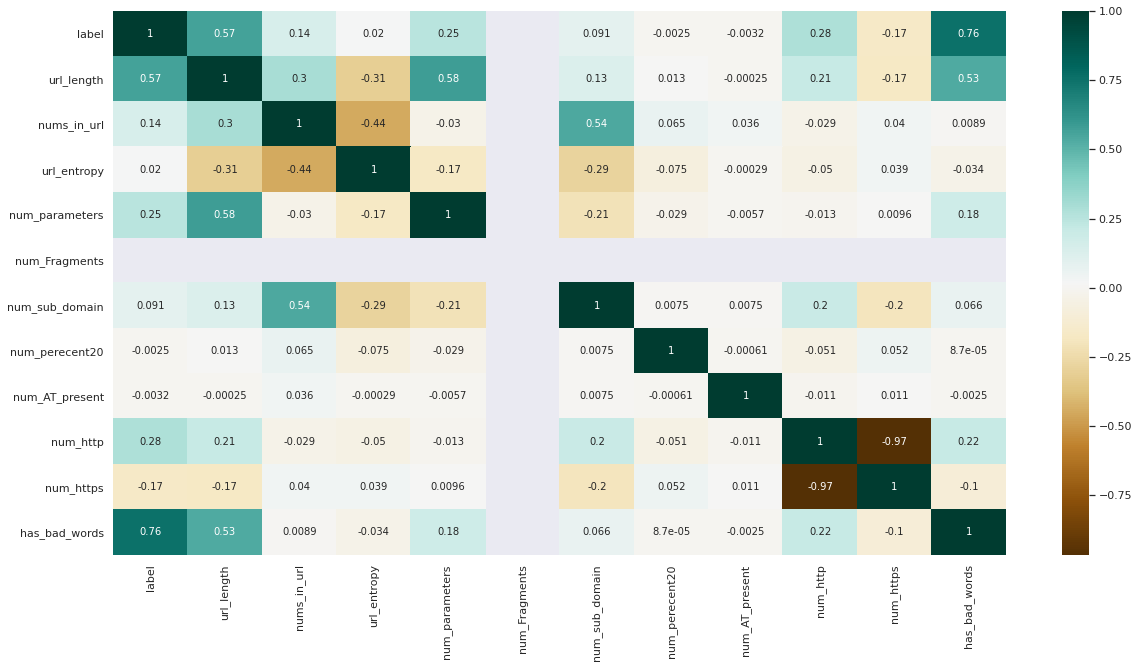

In [ ]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

### Dealing with TEXT features! (NLP :) )

In [ ]:
import gensim
from gensim import corpora
from pprint import pprint

In [ ]:
lst = data["domain"].to_list()

In [ ]:
lst

['www.tirumular.com',
 'mail.bpiexpressonline.org',
 'info.scienceoftheday.com',
 'accounts-google.i-love.xyz',
 'www.weebly.com',
 'paypal.com.web.apps.cgi.bin-problem.accounts.line-sh.work',
 'hydrerasoftware.com',
 'login.live.com',
 'id973972973-83783701.webstarterz.com',
 'info.scienceoftheday.com',
 'www.netflix.com',
 'c9users.io',
 'tirumular.org',
 'shop2day.in',
 'c9users.io',
 'mail.peabodyre.com',
 'r.ar-mtch1.com',
 'government.gateway.sigin.17210.cezoaz.com',
 'webmail.exchange.telmexla.net.co',
 'metaaccount-limited.online',
 'michelproduction.co.za',
 'c9.io',
 'id973972973-83783701.webstarterz.com',
 'justaccount-limited.online',
 'service3.emaildeliveryservice.com',
 'bpiexpressonline.org',
 'c9.io',
 'account.1and1.co.uk',
 'c9.io',
 'chaseonline.chase.com',
 'mail.georgebrown.ca',
 'wellsfargo.com',
 'secure.wellsfargo.com',
 'bpiexpressonline.org',
 'c9.io',
 'account-limitedery.online',
 'www.tirumular.com',
 'michelproduction.co.za',
 'c9.io',
 'appleid.apple.com

In [ ]:
from gensim.models import word2vec

for i, sentence in enumerate(lst):
    tokenized= []
    for word in sentence.split(' '):
        word = word.split('.')[0]
        word = word.lower()
        tokenized.append(word)
    lst[i] = tokenized


In [ ]:
model = word2vec.Word2Vec(lst, workers = 1, min_count = 1, window = 3, sg = 0)
## Output
# Most common word to football is: game

### Dealing with Class Imbalance -- using SMOTE

In [ ]:
# Maybe if we had more time, I can explore using NLP on the domain and subdomain features ( or some other form of label encoding
all_features = data.drop(axis=1, labels =["url", "domain", "domain_extension"])
all_targets = all_features.pop("label")
train_features , test_features, train_targets, test_targets = train_test_split(all_features, all_targets, test_size=0.2)

In [ ]:
# import imbalance data library
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(train_features, train_targets)

# Added approx. 6k more training examples! (for fruadulent rows)
print('Original dataset shape', Counter(train_targets))
print('Resample dataset shape', Counter(y_smote))

# WE use the resampled dataset for training. 
# NOTE that the testing data has not been changed.
train_features, train_targets = x_smote, y_smote

Original dataset shape Counter({0: 6276, 1: 570})
Resample dataset shape Counter({0: 6276, 1: 6276})


In [ ]:
x_smote.head()

,url_length,nums_in_url,url_entropy,num_parameters,num_Fragments,num_sub_domain,num_perecent20,num_AT_present,num_http,num_https,has_bad_words
0,96,7,-4.901660,1,0,3,0,0,True,False,False
1,95,10,-4.682191,0,0,3,0,0,True,False,False
2,59,0,-4.359350,0,0,2,0,0,True,False,False
3,59,1,-4.271871,0,0,1,0,0,True,False,False
4,71,8,-4.610897,0,0,8,0,0,True,False,False


In [ ]:
test_features.head() 

,url_length,nums_in_url,url_entropy,num_parameters,num_Fragments,num_sub_domain,num_perecent20,num_AT_present,num_http,num_https,has_bad_words
6297,77,25,-4.847847,0,0,3,0,0,False,True,False
6079,77,0,-4.521077,1,0,2,0,0,False,True,False
2698,83,5,-4.634589,0,0,2,0,0,False,True,False
6547,66,2,-4.254167,0,0,3,0,0,False,True,False
4029,55,0,-4.381004,0,0,2,0,0,True,False,False


# Modelling & Training

##  Trying NN and sequential models



In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


/home/tahir/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/tahir/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached numpy-1.18.5-cp38-cp38-manylinux1_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.8.2 requires huggingface-hub==0.0.12, but you have huggingface-hub 0.0.13 which is incompatible.
rasa 2.5.0 requires joblib<0.16.0,>=0.15.1, but you have jobli

In [ ]:
!pip install keras

/home/tahir/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/tahir/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

input_dim = len(data.columns)
model = Sequential()
model.add(Dense(256, input_dim = input_dim , activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )


ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (/home/tahir/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/context.py)

In [ ]:
# Initialize all models in a list
models = [DecisionTreeClassifier(max_depth=8),
          # SVC is overfitting like crazy, needs regularization
          SVC(C=1, decision_function_shape="ovo", verbose=True),
          RandomForestClassifier(max_depth=12, n_estimators=100),
          MLPClassifier(hidden_layer_sizes=(100,100),max_iter=1000,alpha=0.01,tol = 0.000000001, solver="lbfgs", verbose=True, activation = "tanh"),
          AdaBoostClassifier(n_estimators=200, learning_rate=0.05),
          GaussianNB(),
          QuadraticDiscriminantAnalysis(reg_param=0),
          GradientBoostingClassifier(verbose=True),
         ]
# Define all the model names
model_names = ["Decision Tree",
               #"SVC",
               "Random Forest",
               #"Neural Net",
               #"Adaboost",
               #"Gaussian Naive Bayes",
               #"QDA",
               #"Gradient Boosting Classifier"
              ]
# Print the data size
print("Training Data size: {}".format(train_features.shape))

# Loop over models instead of having separate cell per model
for name, model in zip(model_names, models):
    # Training and model accuracy
    model.random_state = 0
    print("Training Model :  {}".format(name))
    model.fit(train_features, train_targets)
    print("Done Training {}".format(name))
    test_score = model.score(test_features, test_targets) * 100
    train_score = model.score(train_features, train_targets) * 100
    
    # Predict Y values and see the TP, FP, et c(Using confusion matrix)
    y_pred = model.predict(test_features) # removed the predict.probabilities
    precision, recall, thresholds = metrics.precision_recall_curve(test_targets, y_pred)
    pr_auc = metrics.auc(recall, precision)
    CM = confusion_matrix(test_targets, y_pred)
    TN, FN, TP, FP = CM[0][0], CM[1][0],  CM[1][1], CM[0][1]
    print("{} Train Score : {}".format(name, train_score))
    print("{} Test Score : {}".format(name, test_score))
    print("PR-AUC: {}".format(pr_auc))
    print("# of False Positives: {}".format(FP))
    print("# of True Positives: {}".format(TP))
    print("# of False Negatives: {}".format(FN))
    print("~"*50)
    print("Model Done")
    print("~"*50)

print("*"*50)    
print("~"*50)
print("ALL MODELS DONE")
print("~"*50)
print("*"*50)

Training Data size: (12552, 11)
Training Model :  Decision Tree
Done Training Decision Tree
Decision Tree Train Score : 98.01625239005736
Decision Tree Test Score : 99.06542056074767
PR-AUC: 0.9428367542441721
# of False Positives: 9
# of True Positives: 127
# of False Negatives: 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Done
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training Model :  Random Forest
[LibSVM]Done Training Random Forest
Random Forest Train Score : 85.74729126832378
Random Forest Test Score : 97.60514018691589
PR-AUC: 0.8510535191200208
# of False Positives: 6
# of True Positives: 99
# of False Negatives: 35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Done
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
**************************************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ALL MODELS DONE
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
**************************************************


# RESULTS

In [244]:
print("~"*50)
print("Heuristic Model Results")
print("~"*50)
precision, recall, thresholds = metrics.precision_recall_curve(Heuristic_model["label"], Heuristic_model["predicted_label"])
pr_auc = metrics.auc(recall, precision)
CM = confusion_matrix(Heuristic_model["label"], Heuristic_model["predicted_label"])
TN, FN, TP, FP = CM[0][0], CM[1][0],  CM[1][1], CM[0][1]
print("PR-AUC: {}".format(pr_auc))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("# of False Positives: {}".format(FP))
print("# of True Positives: {}".format(TP))
print("# of False Negatives: {}".format(FN))
# Predict Y values and see the TP, FP, et c(Using confusion matrix)
print("~"*50)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Heuristic Model Results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PR-AUC: 0.9185121373076112
Precision: [0.08674419 0.86762936 1.        ]
Recall: [1.         0.96648794 0.        ]
# of False Positives: 110
# of True Positives: 721
# of False Negatives: 25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
print("~"*50)
print("ML Model -- Gradient Boosting Classifier")
print("~"*50)

# All values are from the last model, GB
precision, recall, thresholds = metrics.precision_recall_curve(test_targets, y_pred) 
pr_auc = metrics.auc(recall, precision)
CM = confusion_matrix(test_targets, y_pred)
TN, FN, TP, FP = CM[0][0], CM[1][0],  CM[1][1], CM[0][1]
print("{} Train Score : {}".format(name, train_score))
print("{} Test Score : {}".format(name, test_score))
print("PR-AUC: {}".format(pr_auc))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("# of False Positives: {}".format(FP))
print("# of True Positives: {}".format(TP))
print("# of False Negatives: {}".format(FN))
print("~"*50)
print("~"*50)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ML Model -- Gradient Boosting Classifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Random Forest Train Score : 85.74729126832378
Random Forest Test Score : 97.60514018691589
PR-AUC: 0.8510535191200208
Precision: [0.07827103 0.94285714 1.        ]
Recall: [1.         0.73880597 0.        ]
# of False Positives: 6
# of True Positives: 99
# of False Negatives: 35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Conclusion and Limitations

Thank you so much for the oppurtunity to participate in this. 
If I had more time, I would have loved to do some of the following: <br>
- Explore more into the synthetic examples made to up the "bad" class.
- I also would have tried to increase the non-ml made model accuracy by adding more patterns such as seeing if a link is live (by checking if theres a response signal), and more. 
- Do some more feature engineering, and Tune the ML models more with grid search to find the best possible parameters.
- Maybe explore baysian optimization to see if error is really as low as possible
<br>

Other than that, we can see the random forest classifier and GB had the most amount of success. 
I would have also loved to do an ensemble of the top 3 models and present that as the main model solution, 
just to lower the chances of false positives as much as possible.<br> 
Thank you once again for the great oppurtunity! 

## PUTTING THE MODEL IN PRODUCTION -- Lets take the 

In [ ]:
model

SVC(C=1, decision_function_shape='ovo', random_state=0, verbose=True)

In [ ]:
model

SVC(C=1, decision_function_shape='ovo', random_state=0, verbose=True)

In [ ]:
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(model, pickle_out)
pickle_out.close()


In [ ]:
test_features[1]

KeyError: 1

In [ ]:
result = model.predict(test_features)